In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

In [19]:
df_train = pd.read_csv('data/tmp/df_grouped.csv')
df_test = pd.read_csv('data/tmp/df_grouped_test.csv')
df_combined = pd.concat([df_test, df_train], ignore_index=True)
df_combined['timestamp'] = pd.to_datetime(df_combined['timestamp'])
df_combined = df_combined.drop(columns=['minute'])
df_combined = df_combined.sort_values(by=['timestamp'],ignore_index=True)
df_combined.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103613 entries, 0 to 103612
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   count         103613 non-null  int64         
 1   timestamp     103613 non-null  datetime64[ns]
 2   dayOfTheWeek  103613 non-null  int64         
 3   isWeekend     103613 non-null  int64         
 4   hours         103613 non-null  int64         
 5   night         103613 non-null  int64         
 6   morning       103613 non-null  int64         
 7   day           103613 non-null  int64         
 8   difference    103613 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(7)
memory usage: 7.1 MB


In [20]:
df_combined

,count,timestamp,dayOfTheWeek,isWeekend,hours,night,morning,day,difference
0,16,2023-07-01 00:00:00,5,0,0,1,0,0,0.0
1,29,2023-07-01 00:01:00,5,0,0,1,0,0,13.0
2,16,2023-07-01 00:02:00,5,0,0,1,0,0,-13.0
3,21,2023-07-01 00:03:00,5,0,0,1,0,0,5.0
4,18,2023-07-01 00:04:00,5,0,0,1,0,0,-3.0
...,...,...,...,...,...,...,...,...,...
103608,25,2023-09-10 23:55:00,6,1,23,0,0,0,7.0
103609,23,2023-09-10 23:56:00,6,1,23,0,0,0,-2.0
103610,17,2023-09-10 23:57:00,6,1,23,0,0,0,-6.0
103611,23,2023-09-10 23:58:00,6,1,23,0,0,0,6.0


In [21]:
#some rough estimation of the anomalies proportion, so we make it a bit higher
print(df_combined.loc[df_combined["count"] > 60].size/df_combined.size)
anom_proportion = 0.001

0.0005790779149334543


## Kmeans

In [22]:
df_kmeans =  df_combined[['count','dayOfTheWeek','isWeekend','hours','night','morning','day','difference']]
min_max_scaler = preprocessing.StandardScaler()
df_kmeans = pd.DataFrame(min_max_scaler.fit_transform(df_kmeans), columns=['count','dayOfTheWeek','isWeekend','hours','night','morning','day','difference'])
df_kmeans

,count,dayOfTheWeek,isWeekend,hours,night,morning,day,difference
0,-0.633556,0.958330,-0.424100,-1.662250,1.733713,-0.577495,-0.57751,-0.000005
1,0.489346,0.958330,-0.424100,-1.662250,1.733713,-0.577495,-0.57751,1.216606
2,-0.633556,0.958330,-0.424100,-1.662250,1.733713,-0.577495,-0.57751,-1.216616
3,-0.201670,0.958330,-0.424100,-1.662250,1.733713,-0.577495,-0.57751,0.467922
4,-0.460801,0.958330,-0.424100,-1.662250,1.733713,-0.577495,-0.57751,-0.280762
...,...,...,...,...,...,...,...,...
103608,0.143838,1.454427,2.357936,1.660871,-0.576797,-0.577495,-0.57751,0.655093
103609,-0.028916,1.454427,2.357936,1.660871,-0.576797,-0.577495,-0.57751,-0.187176
103610,-0.547179,1.454427,2.357936,1.660871,-0.576797,-0.577495,-0.57751,-0.561518
103611,-0.028916,1.454427,2.357936,1.660871,-0.576797,-0.577495,-0.57751,0.561507


In [23]:
pca = PCA(n_components=2)
df_kmeans = pca.fit_transform(df_kmeans)
min_max_scaler = preprocessing.StandardScaler()
df_kmeans = pd.DataFrame(min_max_scaler.fit_transform(df_kmeans))
df_kmeans

,0,1
0,1.602231,0.419180
1,1.118598,0.509098
2,1.743345,0.378897
3,1.416218,0.453764
4,1.582100,0.417520
...,...,...
103608,-0.898972,2.026737
103609,-0.748582,1.991212
103610,-0.547077,1.955909
103611,-0.835422,2.016002


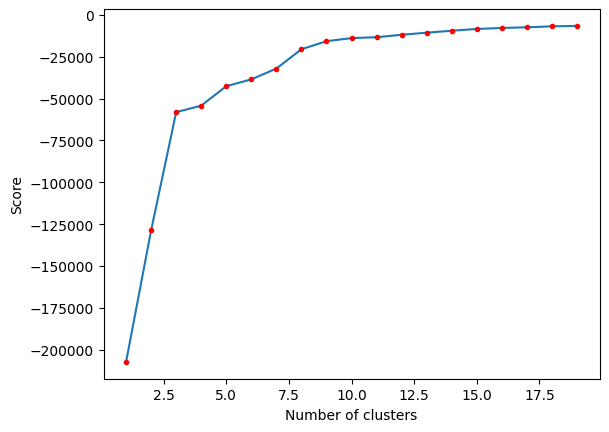

In [24]:
# calculate with different number of centroids to see the loss plot (elbow method)
kmeans = [KMeans(n_clusters=i, random_state=42).fit(df_kmeans) for i in range(1, 20)]
scores = [kmeans[i].score(df_kmeans) for i in range(len(kmeans))]
plt.plot(range(1, 20), scores)
plt.plot(range(1, 20), scores, 'r.')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.show()

In [25]:
df_combined['cluster'] = kmeans[7].predict(df_kmeans)
df_combined['PC1'] = df_kmeans[0]
df_combined['PC2'] = df_kmeans[1]
df_combined['cluster'].value_counts()

cluster
0    20358
7    18968
4    13823
3    12856
2    11852
1    11057
5    10752
6     3947
Name: count, dtype: int64

In [26]:
df_combined["distances"] = np.min(kmeans[8].transform(df_kmeans), axis=1)
threshold = np.percentile(df_combined["distances"], 100 * (1 - anom_proportion))

df_combined["KmeansQAnomaly"] = df_combined["distances"].apply(lambda x: int(x > threshold))
df_combined.loc[df_combined["KmeansQAnomaly"] == 1]

,count,timestamp,dayOfTheWeek,isWeekend,hours,night,morning,day,difference,cluster,PC1,PC2,distances,KmeansQAnomaly
946,62,2023-07-01 15:46:00,5,0,15,0,0,1,19.0,0,-2.070095,0.365268,1.316331,1
979,57,2023-07-01 16:19:00,5,0,16,0,0,1,19.0,0,-1.990901,0.338703,1.232805,1
986,56,2023-07-01 16:26:00,5,0,16,0,0,1,20.0,0,-1.975409,0.337983,1.217942,1
987,63,2023-07-01 16:27:00,5,0,16,0,0,1,7.0,0,-2.018728,0.324427,1.254609,1
1003,57,2023-07-01 16:43:00,5,0,16,0,0,1,19.0,0,-1.990901,0.338703,1.232805,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100842,403,2023-09-09 01:49:00,5,0,1,1,0,0,395.0,2,-12.934551,3.113285,6.972558,1
100843,11,2023-09-09 01:50:00,5,0,1,1,0,0,-392.0,5,5.936549,-0.822071,4.384080,1
101755,54,2023-09-09 17:02:00,5,0,17,0,0,1,24.0,0,-2.018677,0.335267,1.257976,1
103200,48,2023-09-10 17:07:00,6,1,17,0,0,1,12.0,2,-1.804000,2.081391,1.183140,1


In [27]:
anomaly = df_combined.loc[df_combined['KmeansQAnomaly'] == 1, ['timestamp', 'count']]
anomaly.size

208

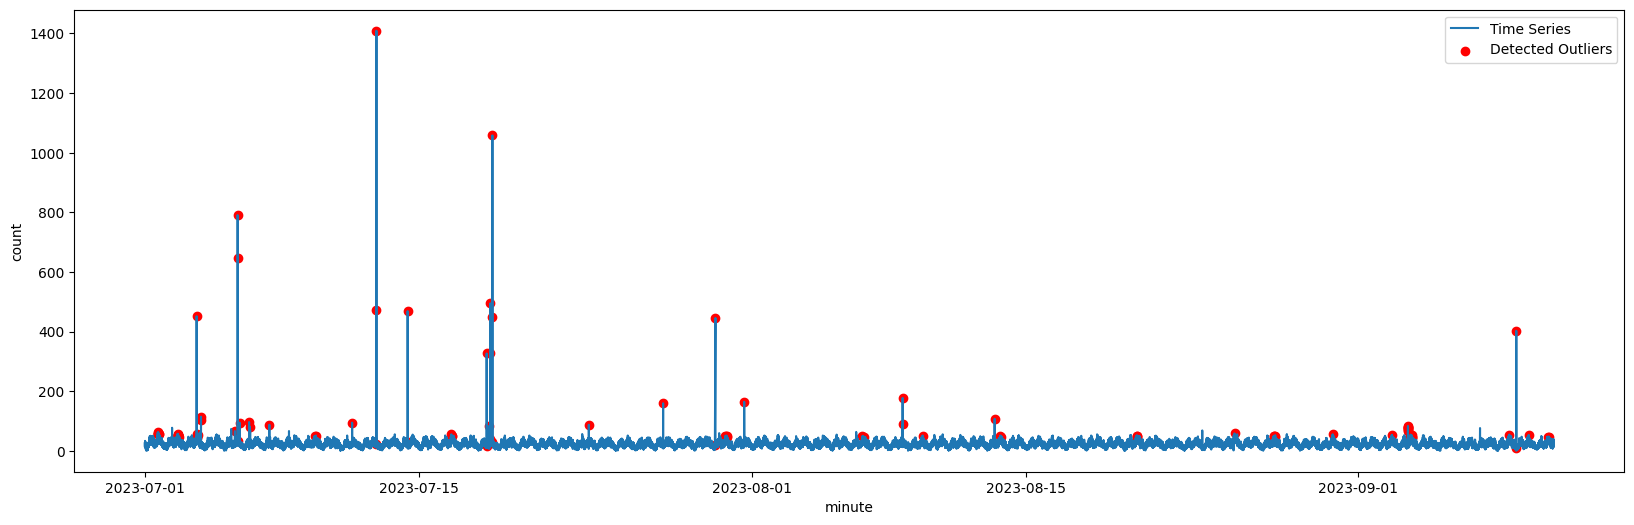

In [28]:
plt.figure(figsize=(20, 6))
plt.plot(df_combined['timestamp'], df_combined['count'], label='Time Series')
plt.scatter(anomaly['timestamp'],anomaly['count'], color='red', label='Detected Outliers')
plt.xlabel('minute')
plt.ylabel('count')
plt.legend()
plt.show()

In [31]:
df_combined = df_combined.drop(columns=['cluster', 'PC1', 'PC2', 'distances'])
df_combined.head()

,count,timestamp,dayOfTheWeek,isWeekend,hours,night,morning,day,difference,KmeansQAnomaly
0,16,2023-07-01 00:00:00,5,0,0,1,0,0,0.0,0
1,29,2023-07-01 00:01:00,5,0,0,1,0,0,13.0,0
2,16,2023-07-01 00:02:00,5,0,0,1,0,0,-13.0,0
3,21,2023-07-01 00:03:00,5,0,0,1,0,0,5.0,0
4,18,2023-07-01 00:04:00,5,0,0,1,0,0,-3.0,0


## Gausian model

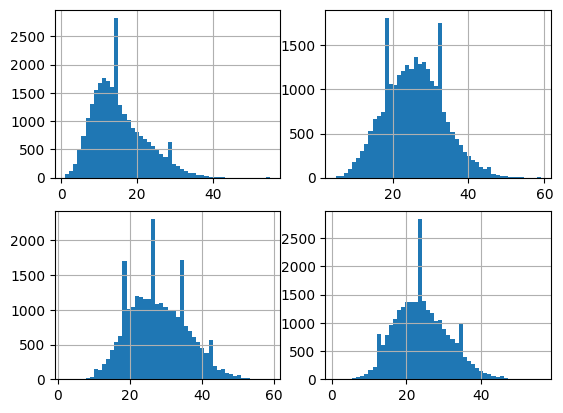

In [35]:
#for easier observation
df_restricted = df_combined.loc[df_combined['count'] < 60]
night = df_restricted.loc[df_restricted['night'] == 1, 'count']
morning = df_restricted.loc[df_restricted['morning'] == 1, 'count']
day = df_restricted.loc[df_restricted['day'] == 1, 'count']
evening = df_restricted.loc[(df_restricted['night'] + df_restricted['morning'] + df_restricted['day'] == 0), 'count']

fig, axs = plt.subplots(2,2)
night.hist(ax=axs[0,0],bins=50)
morning.hist(ax=axs[0,1],bins=50)
day.hist(ax=axs[1,0],bins=50)
evening.hist(ax=axs[1,1],bins=50)
night.set_title("night")
morning.set_title("morning")
day.set_title("day")
evening.set_title("evening")

#actual data
night = df_combined.loc[df_combined['night'] == 1, 'count']
morning = df_combined.loc[df_combined['morning'] == 1, 'count']
day = df_combined.loc[df_combined['day'] == 1, 'count']
evening = df_combined.loc[(df_combined['night'] + df_combined['morning'] + df_combined['day'] == 0), 'count']


In [36]:
envelope =  EllipticEnvelope(contamination = anom_proportion, random_state = 42) 
night_stand = night.values.reshape(-1,1)
envelope.fit(night_stand)
night = pd.DataFrame(night)
night['deviation'] = envelope.decision_function(night_stand)
night['anomaly'] = envelope.predict(night_stand)

envelope =  EllipticEnvelope(contamination = anom_proportion, random_state = 42) 
morning_stand = morning.values.reshape(-1,1)
envelope.fit(morning_stand)
morning = pd.DataFrame(morning)
morning['deviation'] = envelope.decision_function(morning_stand)
morning['anomaly'] = envelope.predict(morning_stand)

envelope =  EllipticEnvelope(contamination = anom_proportion, random_state = 42) 
day_stand = day.values.reshape(-1,1)
envelope.fit(day_stand)
day = pd.DataFrame(day)
day['deviation'] = envelope.decision_function(day_stand)
day['anomaly'] = envelope.predict(day_stand)

envelope =  EllipticEnvelope(contamination = anom_proportion, random_state = 42) 
evening_stand = evening.values.reshape(-1,1)
envelope.fit(evening_stand)
evening = pd.DataFrame(evening)
evening['deviation'] = envelope.decision_function(evening_stand)
evening['anomaly'] = envelope.predict(evening_stand)

In [47]:
# add the data to the main 
df_gausian = pd.concat([night, morning, day, evening])
df_gausian["anomaly"] = df_gausian["anomaly"].apply(lambda x: 0 if x == 1 else 1) 
df_combined["GausianAnomaly"] = df_gausian["anomaly"]
df_combined.head()

,count,timestamp,dayOfTheWeek,isWeekend,hours,night,morning,day,difference,KmeansQAnomaly,GausianAnomaly
0,16,2023-07-01 00:00:00,5,0,0,1,0,0,0.0,0,0
1,29,2023-07-01 00:01:00,5,0,0,1,0,0,13.0,0,0
2,16,2023-07-01 00:02:00,5,0,0,1,0,0,-13.0,0,0
3,21,2023-07-01 00:03:00,5,0,0,1,0,0,5.0,0,0
4,18,2023-07-01 00:04:00,5,0,0,1,0,0,-3.0,0,0


In [48]:
anomaly = df_combined.loc[df_combined['GausianAnomaly'] == 1, ['timestamp', 'count']]
anomaly.size

204

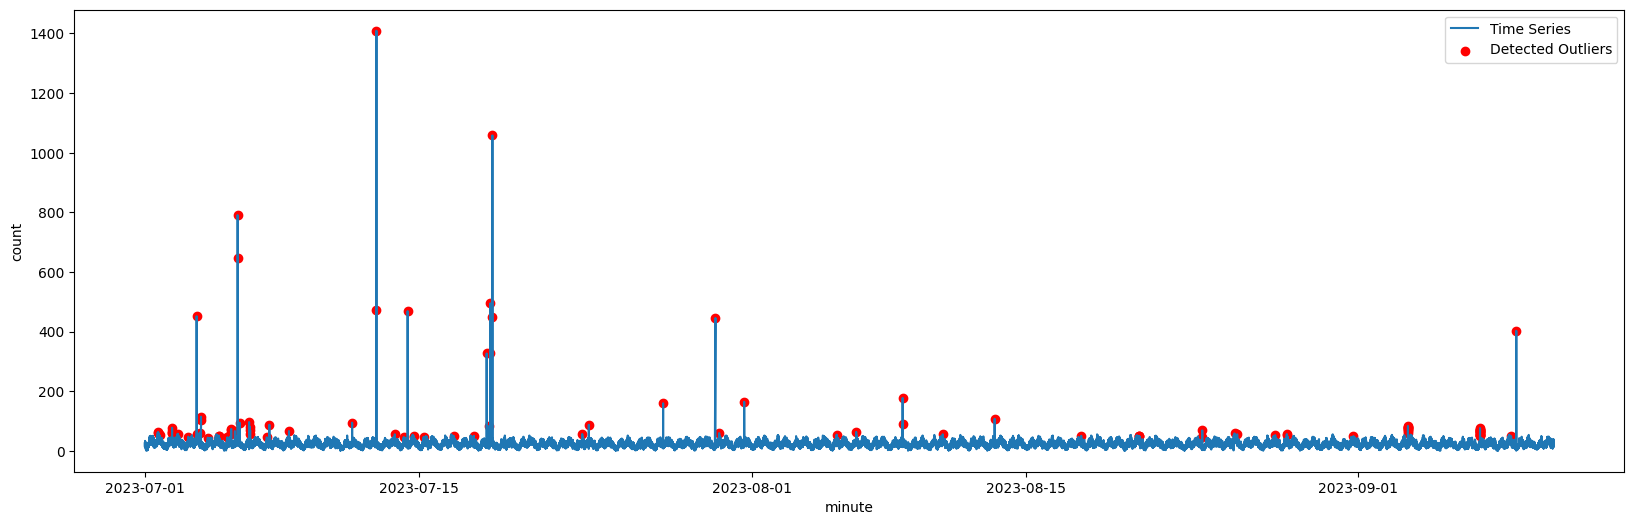

In [49]:
plt.figure(figsize=(20, 6))
plt.plot(df_combined['timestamp'], df_combined['count'], label='Time Series')
plt.scatter(anomaly['timestamp'],anomaly['count'], color='red', label='Detected Outliers')
plt.xlabel('minute')
plt.ylabel('count')
plt.legend()
plt.show()

## Isolation forest

In [65]:
df_iForest =  df_combined[['count','difference']] #'dayOfTheWeek','isWeekend','hours','night','morning','day', - done some experiments, and this combo outperformed others

min_max_scaler = preprocessing.StandardScaler()
df_iForest = min_max_scaler.fit_transform(df_iForest)
df_iForest = pd.DataFrame(df_iForest)

model =  IsolationForest(contamination = anom_proportion, random_state = 42)
model.fit(df_iForest)

df_combined['iForestAnomaly'] = pd.Series(model.predict(df_iForest))
df_combined['iForestAnomaly'] = df_combined['iForestAnomaly'].apply(lambda x: 0 if x == 1 else 1) 
print(df_combined['iForestAnomaly'].value_counts())



iForestAnomaly
0    103512
1       101
Name: count, dtype: int64


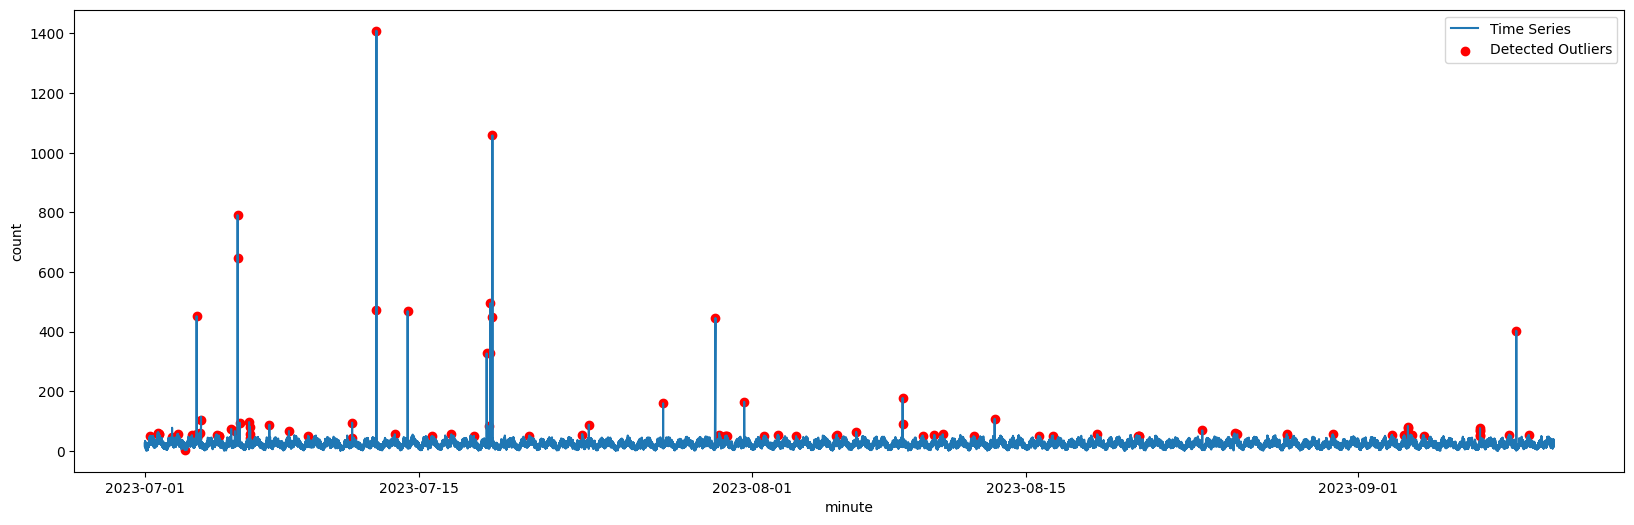

In [66]:
anomaly = df_combined.loc[df_combined['iForestAnomaly'] == 1, ['timestamp', 'count']]
plt.figure(figsize=(20, 6))
plt.plot(df_combined['timestamp'], df_combined['count'], label='Time Series')
plt.scatter(anomaly['timestamp'],anomaly['count'], color='red', label='Detected Outliers')
plt.xlabel('minute')
plt.ylabel('count')
plt.legend()
plt.show()

## One class SVM